In [37]:
import json
from pprint import pprint
import csv
import re
import gzip
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#this cell opens the metadata file and create list with: files = [case_id,file_id,file_name]
with open('../kidney clinical data/metadata.cart.2018-11-01.json') as data_file:    
    data = json.load(data_file)

#initialize the array to hold the information
files = []
    
for n in range(len(data)):
    #remove the TARGET project files since clinical data doesn't match
    if not bool('TARGET' in data[n]['associated_entities'][0]['entity_submitter_id']):
        files.append([data[n]['associated_entities'][0]['case_id'],data[n]['file_id'],data[n]['file_name']])
    
pprint(files[0:3])

[['88c91a7b-5c41-4361-85d0-da759ab94204',
  'adadde58-de3b-4cf7-908b-5057831e400e',
  'c08817f0-fc05-44ea-8a92-8b7538ac49d8.FPKM.txt.gz'],
 ['74749fe8-f5d0-4d0d-8c7a-e56eba6503b3',
  'aa7770a2-6fbb-4693-8378-3b5de332deca',
  '3704029d-0bb1-40b5-b666-610174d521c2.FPKM.txt.gz'],
 ['88e7ce26-5b3f-4e4e-89b7-f706063fc467',
  '0e345952-6f09-4e61-b9a9-e8f809bf21e0',
  '6073b31e-7ce7-423e-a9b2-a85e3e9bc62e.FPKM.txt.gz']]


In [28]:
clinical_data = []

with open('../kidney clinical data/clinical.tsv') as tsvin:
    tsvin = csv.reader(tsvin, delimiter='\t')
    
    firstline=True
    
    for row in tsvin:
        if firstline:
            firstline=False
        else:
        # the TARGET project stores data in the wrong columns so ignore those
            if not bool('TARGET' in str(row[1])):
                clinical_data.append(row[0])
                clinical_data.append(row[4])
                clinical_data.append(row[12])
                clinical_data.append(row[13])
                clinical_data.append(row[15])
                clinical_data.append(row[24])

clinical_data[0:3]

['1a726069-0b44-42ad-9a20-0ee90b31796b', '1954', '20708']

In [51]:
#grab FPKM data from files
with gzip.open('../kidney FPKM data/'+files[0][1]+'/'+files[0][2], 'rb') as f:
    row_count = sum(1 for row in f)
    
# FPKM_data will store all FPKM data in a row for all patients in the clinical data set
FPKM_data = np.zeros((len(files),row_count+2))

for n in range(len(files)):
    with gzip.open('../kidney FPKM data/'+files[n][1]+'/'+files[n][2], 'rb') as f:
        m=2
        # add: status (0=dead, 1=alive), days at last check or days at death
        index=clinical_data.index(files[n][0])
        if clinical_data[index+3]=='alive' and not clinical_data[index+5]=='--':
            FPKM_data[n,0]=1
            FPKM_data[n,1]=float(clinical_data[index+5])
        if clinical_data[index+3]=='dead' and not clinical_data[index+4]=='--':
            FPKM_data[n,0]=0
            FPKM_data[n,1]=float(clinical_data[index+4])
        for line in f:
            string=str(line)
            FPKM_data[n,m]=float(string[string.find('\\t')+2:string.find('\\n')])
            m=m+1
                
print(FPKM_data[0,0:5])

[  1.00000000e+00   3.98900000e+03   7.65900057e-02   1.46122715e-01
   1.68854992e+00]


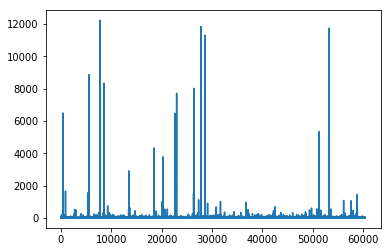

In [38]:
plt.plot(FPKM_data[0,2:])
plt.show()

In [39]:
from sklearn import tree

In [61]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(FPKM_data[:,3:], FPKM_data[:,0])

In [62]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

In [15]:
np.zeros((3,5),dtype='string')

TypeError: data type "string" not understood

In [23]:
test=np.array(clinical_data)

In [21]:
test[:,0].index('2797088e-f534-4c1e-abf8-cc6f832cd911')

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [52]:
FPKM_data.shape

(1023, 60485)

In [45]:
len(files)

1023